This notebook contains the code for reproducing Figures 1 and 2 of the report. 

## Load data and preprocess

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
sns.set(rc={'figure.figsize':(14,8)})

In [2]:
dfs = []
for f in glob('lichess_db_analyzed_2019*.csv'):
    dfs.append(pd.read_csv(f))
df = pd.concat(dfs)

df['UTCDate'] = pd.to_datetime(df.UTCDate)

In [3]:
print('Games Before processing',len(df))

#drop any potential bad data we got from parsing
#for example games with only 1 move or no Rating for some side
df = df.dropna()

#remove Correspondence games
df = df[df.Event!='C']

#remove short games
df = df[df.gameLength>=10] 

#remove large acpl
df = df[df.whiteACPL<=500]
df = df[df.blackACPL<=500]

#remove extreme Elos 
df = df[df.WhiteElo>=800]
df = df[df.BlackElo>=800] 
df = df[df.WhiteElo<=2750] 
df = df[df.BlackElo<=2750]

#remove aborted games
df = df[df.Result!='?']

#remove provisional or cheated games
df = df[df.Termination!='?'] 

#Rename Elo to rating
df = df.rename(columns={'WhiteElo': 'White Rating', 'BlackElo': 'Black Rating', 'Event':'Time Control'})

#bin Elo for plotting
bins = np.arange(min(min(df['White Rating']),min(df['Black Rating'])),
                 max(max(df['White Rating'])+1,max(df['Black Rating'])+1),150)
labels=[str(x)+'-'+str(y) for x,y in zip(bins,bins[1:])]
df['White Rating Range'] = pd.cut(df['White Rating'], bins, labels=labels)
df['Black Rating Range'] = pd.cut(df['Black Rating'], bins, labels=labels)

#Rename Time controls for plotting
df['Time Control'] = df['Time Control'].replace({'b':'Bullter', 'B':'Blitz', 'R':'Rapid', 'c':'Classical'})


print('Games after processing',len(df))


Games Before processing 26155459
Games after processing 25925288


# Figure 1
The time control has a big impact on the acpl, so we should analyze each own on its own.
The same hold for the side of the player (white or black)


In [4]:
print(df['Time Control'].value_counts())

Blitz        11233853
Rapid         5870412
Bullter       5551209
Classical     3269814
Name: Time Control, dtype: int64


In [5]:
#could have used groupby
bullet = df[df['Time Control'] == 'Bullet']
blitz = df[df['Time Control'] == 'Blitz']
rapid = df[df['Time Control'] == 'Rapid']
classical = df[df['Time Control'] == 'Classical']  

all_modes = [bullet, blitz, rapid, classical]


In [6]:
means = pd.pivot_table(df, values=['whiteACPL','blackACPL'], index=['Time Control'], 
               aggfunc=np.mean)
count = pd.pivot_table(df, values=['whiteACPL'], index=['Time Control'], 
               aggfunc='count')
count.columns = ['Count']
means.columns = ['black ACPL', 'white ACPL']
table = means.join(count)
table = table.apply(lambda x: round(x, 2))
#print(table.to_latex())
table

,black ACPL,white ACPL,Count
Time Control,,,
Blitz,75.34,72.88,11233853
Bullter,84.01,82.12,5551209
Classical,74.88,72.39,3269814
Rapid,74.11,71.76,5870412


In [7]:
df_melted = pd.DataFrame([('white',x,y,z) for x,y,z in zip(df.whiteACPL,df['White Rating Range'],df['Time Control'])] + 
                          [('black',x,y,z) for x,y,z in zip(df.blackACPL,df['Black Rating Range'],df['Time Control'])], 
                         columns = ['Side','ACPL','Rating Range','Time Control'])

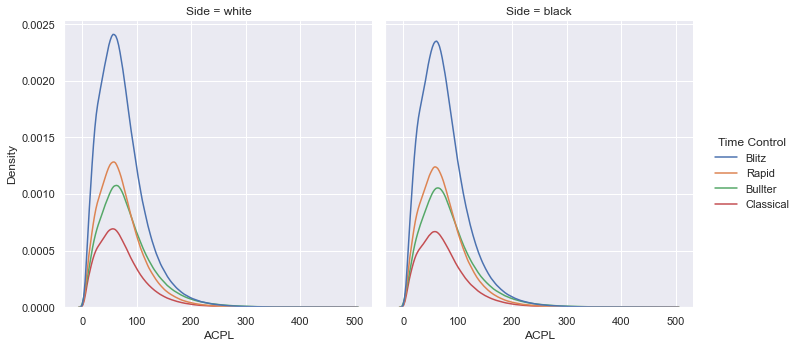

In [8]:
sns.displot(data=df_melted, x="ACPL", col="Side", hue="Time Control", kind='kde')


# Figure 2

(-5.0, 300.0)

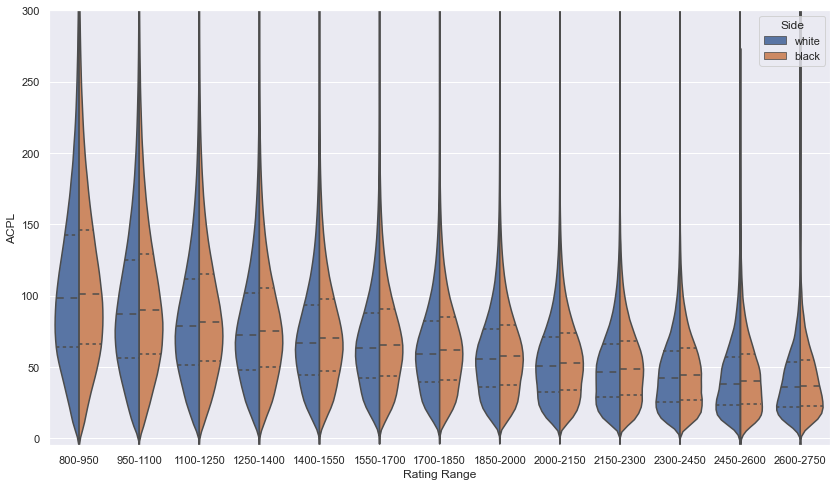

In [9]:
sns.violinplot(data=df_melted[df_melted['Time Control']=='Blitz'], order=labels, hue='Side', split=True, 
               x="Rating Range", y="ACPL", inner="quartile" )
plt.ylim(-5, 300)